In [1]:
!pip install torch torchvision


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [2]:
!pip install scikit-learn


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [3]:
!pip install tqdm


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [4]:
!pip install pandas


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [1]:
import torch
import torch.nn as nn
from torchvision import models
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.transforms.functional import to_pil_image
from PIL import Image
import os
import pandas as pd
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score


/central/groups/CS156b/2025/CodeMonkeys/.venv/lib64/python3.9/site-packages/networkx/utils/backends.py:135: RuntimeWarning: networkx backend defined more than once: nx-loopback
  backends.update(_get_backends("networkx.backends"))


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# CHANGE THIS

In [19]:
##MAKE SURE TO CHANGE THIS
best_model_path = "models/nf_d1.pth"
target_col = 'No Finding'

In [26]:
class CSVDataset(Dataset):
    def __init__(self, dataframe, image_root_dir, target_columns=None, transform=None,
                 save_dir=None, use_saved_images=False):
        self.data = dataframe
        self.image_root_dir = image_root_dir
        self.target_columns = target_columns
        self.transform = transform
        self.save_dir = save_dir
        self.use_saved_images = use_saved_images

        if self.save_dir:
            os.makedirs(self.save_dir, exist_ok=True)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        
        # Use index for the saved tensor filename
        image_index = row['Unnamed: 0']
        saved_image_path = os.path.join(self.save_dir, f"{image_index}.pt")

        if self.use_saved_images:
            if os.path.exists(saved_image_path):
                image_tensor = torch.load(saved_image_path)
            else:
                raise FileNotFoundError(f"Saved tensor not found: {saved_image_path}")
        else:
            original_image_path = os.path.join(self.image_root_dir, row['Path'])
            image = Image.open(original_image_path).convert("L")
            image_tensor = self.transform(image) if self.transform else transforms.ToTensor()(image)

            if self.save_dir:
                torch.save(image_tensor, saved_image_path)

        if self.target_columns:
            labels = pd.to_numeric(row[self.target_columns], errors='coerce').fillna(0).astype(float).values
            labels = torch.tensor(labels, dtype=torch.float32)
            return image_tensor, labels

        return image_tensor

In [27]:
class MultiLabelResNet50(nn.Module):
    def __init__(self, num_classes, hidden_dim = 512, dropout_rate = 0.5):
        super(MultiLabelResNet50, self).__init__()
        
        # Load pre-trained ResNet50
        self.base_model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
        
        # Modify the fully connected layer for multi-label classification
        self.base_model.fc = nn.Sequential(
            nn.Linear(self.base_model.fc.in_features, hidden_dim),  # New intermediate layer. ##512 --> 256
            nn.ReLU(),
            nn.Dropout(dropout_rate),  # Dropout to prevent overfitting ##0.5 --> 0.6
            nn.Linear(hidden_dim, num_classes),  # Output layer
            nn.Sigmoid()  # Sigmoid for multi-label classification (soften the data)
            #nn.Tanh()  #This is between -1 and 1

           # nn.Linear(self.base_model.fc.in_features, num_classes),
           # nn.Sigmoid()  # Sigmoid activation for multi-label classification
        )

    def forward(self, x):
        return self.base_model(x)

In [9]:
class MultiLabelResNet50_2(nn.Module):
    def __init__(self, num_classes):
        super(MultiLabelResNet50_2, self).__init__()
        
        # Load pre-trained ResNet50
        self.base_model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
        
        # Modify the fully connected layer for multi-label classification
        self.base_model.fc = nn.Sequential(
            nn.Linear(self.base_model.fc.in_features, 256),  # New intermediate layer. ##512 --> 256
            nn.ReLU(),
            nn.Dropout(0.6),  # Dropout to prevent overfitting ##0.5 --> 0.6
            nn.Linear(256, num_classes),  # Output layer
            nn.Sigmoid()  # Sigmoid for multi-label classification (soften the data)
            #nn.Tanh()  #This is between -1 and 1

           # nn.Linear(self.base_model.fc.in_features, num_classes),
           # nn.Sigmoid()  # Sigmoid activation for multi-label classification
        )

    def forward(self, x):
        return self.base_model(x)

In [28]:
class MultiLabelDenseNet121(nn.Module):
    def __init__(self, num_classes, hidden_dim = 512):
        super(MultiLabelDenseNet121, self).__init__()

        # Load pre-trained DenseNet-121
        self.base_model = models.densenet121(weights=models.DenseNet121_Weights.IMAGENET1K_V1)
        
        # Replace the classifier with a custom head
        self.base_model.classifier = nn.Sequential(
            nn.Linear(self.base_model.classifier.in_features, hidden_dim),  
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(hidden_dim, num_classes),
            nn.Tanh()  # Output values in [-1, 1] for each class
        )

    def forward(self, x):
        return self.base_model(x)

In [29]:
image_root = '/central/groups/CS156b/2025/CodeMonkeys/input_images'
image_root_dir = "input_images/train"
train_save_dir = os.path.join(image_root, 'train')

def get_filtered_df(col, num=None):
    
    #test_save_dir = os.path.join(image_root, 'test')
    full_train_df = pd.read_csv('train2023.csv')
    #print(len(full_train_df))
    #filtered_train_df = full_train_df.iloc[:29692]
    if num != None:
        full_train_df = full_train_df.iloc[:num]

    filtered_train_df = full_train_df.dropna(subset=[col]).copy()
    filtered_train_df[col] = (filtered_train_df[col] + 1) / 2
    #filtered_train_df = filtered_train_df[filtered_train_df[col] != 0.5]  # Drop rows with 'Pleural_Effusion' == 0
    return filtered_train_df

filtered_train_df = get_filtered_df(target_col)
#print(len(filtered_train_df))

In [11]:
##DONT GENERALLY WANT THIS
label_counts = filtered_train_df[target_col].value_counts()

# Get majority class (should be 1.0)
majority_class = label_counts.idxmax()

# Separate the majority and minority classes
majority_df = filtered_train_df[filtered_train_df[target_col] == majority_class]
minority_df = filtered_train_df[filtered_train_df[target_col] != majority_class]

# Randomly sample 10,000 from the majority class
majority_df = majority_df.sample(n=10000, random_state=42)
minority_df = minority_df.sample(n=10000, random_state=42)

# Combine back
balanced_df = pd.concat([majority_df, minority_df]).sample(frac=1, random_state=42).reset_index(drop=True)
filtered_train_df = balanced_df

In [30]:
##DONT GENERALLY WANT THIS
# # Define desired number of samples per class
sample_sizes = {
    0.0: 15000,
    0.5: 7000,
    1.0: 15000
}

dfs = []
for label, n_samples in sample_sizes.items():
    class_df = filtered_train_df[filtered_train_df[target_col] == label]
    # Sample with replacement if not enough data
    sampled_df = class_df.sample(n=n_samples, replace=(n_samples > len(class_df)), random_state=42)
    dfs.append(sampled_df)

# Combine and shuffle
balanced_df = pd.concat(dfs).sample(frac=1, random_state=42).reset_index(drop=True)
filtered_train_df = balanced_df


In [31]:
label_counts = filtered_train_df[target_col].value_counts()
print(label_counts)

No Finding
1.0    15000
0.0    15000
0.5     7000
Name: count, dtype: int64


In [24]:
print(filtered_train_df["Frontal/Lateral"].value_counts())

Frontal/Lateral
Frontal    28873
Lateral     8127
Name: count, dtype: int64


In [32]:
from sklearn.model_selection import train_test_split

# Define your target columns once
target_columns = [target_col]

# Step 1: Split the dataframe
train_df, val_df = train_test_split(filtered_train_df, test_size=0.15, random_state=42)

##MAY WANT TO GET RID OF THESE
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

# Step 2: Create training dataset
train_dataset = CSVDataset(
    dataframe=train_df, 
    image_root_dir=image_root, 
    target_columns=target_columns, 
    save_dir=train_save_dir, 
    use_saved_images=True
)

# Step 3: Create validation dataset
val_dataset = CSVDataset(
    dataframe=val_df, 
    image_root_dir=image_root, 
    target_columns=target_columns, 
    save_dir=train_save_dir, 
    use_saved_images=True
)

# Step 4: Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True) ##64 --> 32
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

In [10]:
##This is for oversampling
fracture_labels = train_df[target_col].values
label_map = {0.0: 0, 0.5: 1, 1.0: 2}
mapped_labels = np.array([label_map[float(lbl)] for lbl in fracture_labels])

class_counts = np.bincount(mapped_labels)
weights = 1. / (class_counts + 1e-6)
sample_weights = torch.tensor(weights[mapped_labels], dtype=torch.float)

sampler = torch.utils.data.WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)
train_loader = DataLoader(train_dataset, batch_size=16, sampler=sampler)

In [33]:
def freeze_base_layers_dn(model):
    """
    Freeze initial layers of DenseNet-121 up to denseblock3.
    """
    freeze = True
    for name, child in model.base_model.features.named_children():
        if name == 'denseblock1':
            freeze = False
        if freeze:
            for param in child.parameters():
                param.requires_grad = False
    return model

In [14]:
def freeze_base_layers(model, until_layer=6):
    """
    Freeze layers of ResNet-50 up to a certain stage (e.g., until_layer=6 means keep layers 0-5 frozen).
    """
    child_counter = 0
    for child in model.base_model.children():
        if child_counter < until_layer:
            for param in child.parameters():
                param.requires_grad = False
        child_counter += 1
    return model


In [34]:
uncertain_weight_factor = 0.25
class_weights = {}

# Loop over each target column
for col in target_columns:
    # Count the occurrences of each class in the column
    counts = filtered_train_df[col].value_counts()
    total = len(filtered_train_df[col])
    
    # Calculate class weights using inverse frequency (you can also experiment with other strategies)
    weights = {
        0: total / (counts.get(0, 0) + 1),  # Add 1 to avoid division by zero
        0.5: total / (counts.get(0.5, 0) + 1) * uncertain_weight_factor,
        1: total / (counts.get(1, 0) + 1)
    }
    
    # Store weights for each class
    class_weights[col] = weights
class_weights[target_col] = {0: 1.0, 0.5: 1.0, 1: 1.0}  ##GET RID OF THIS LINE IF DONT HAVE SAMPLER
# Example: Print out the weights for each class
for col in target_columns:
    print(f"Class weights for {col}: {class_weights[col]}")


Class weights for No Finding: {0: 1.0, 0.5: 1.0, 1: 1.0}


In [35]:
criterion = nn.MSELoss(reduction='none')

'''def masked_MSE_loss(output, target, class_weights):
    # Create a mask for non-NaN target values
    mask = ~torch.isnan(target)
    
    # Apply the MSE loss
    loss = criterion(output, target)
    
    # Loop through each class and apply the class weights
    for class_idx, col in enumerate(target_columns):
        # Get the class values for the current class
        class_values = target[:, class_idx]
        
        # Apply the class weights to each class value
        weight = torch.tensor([class_weights[col].get(x.item(), 1) for x in class_values], dtype=torch.float32, device=output.device)
        
        # Apply the weight to the loss (broadcast the weight to match the loss shape)
        loss = loss * mask  # Apply mask to exclude NaN targets
        loss[:, class_idx] *= weight  # Apply weight per class
    
    # Return mean loss for valid entries
    return loss.sum() / mask.sum()'''

def masked_MSE_loss(output, target, class_weights):
    # Compute element-wise MSE
    loss = criterion(output, target)  # shape: [batch_size, 1]

    # Get weights per target value (assume target values are 0.0, 0.5, or 1.0)
    weights = torch.tensor([class_weights.get(float(val.item()), 1.0) for val in target.squeeze()],
                           dtype=torch.float32,
                           device=output.device).unsqueeze(1)  # shape: [batch_size, 1]

    # Apply weights to loss
    weighted_loss = loss * weights

    return weighted_loss.mean()


## No Grid Search

In [36]:
##NEW VERSION FOR FRACTURE and using for NF
import numpy as np
import torch
import torch.optim as optim
import os

# Hyperparameters and model setup
num_classes = 1  # Predicting 'Pleural Effusion'
model = MultiLabelDenseNet121(num_classes=num_classes, hidden_dim = 216).to(device)
model = freeze_base_layers_dn(model)  # Freeze layers
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)

# Early stopping parameters
early_stopping_patience = 3
best_val_loss = float('inf')
patience_counter = 0
os.makedirs("models", exist_ok=True)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=1)


num_epochs = 30
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for batch_idx, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = masked_MSE_loss(outputs, labels, class_weights)
        running_loss += loss.item()

        loss.backward()
        optimizer.step()

        predicted_class = torch.where(outputs > 0.5, torch.tensor(1.0).to(device),
                                      torch.where(outputs < -0.5, torch.tensor(-1.0).to(device), torch.tensor(0.0).to(device)))
        correct += (predicted_class == labels).sum().item()
        total += labels.numel()

    avg_loss = running_loss / len(train_loader)
    accuracy = correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")

    # Validation phase
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = masked_MSE_loss(outputs, labels, class_weights)
            val_loss += loss.item()

            predicted_class = torch.where(
                outputs < 0.25, torch.tensor(0.0).to(device),
                torch.where(
                    outputs < 0.75, torch.tensor(0.5).to(device),
                    torch.tensor(1.0).to(device)
                )
            )

            all_preds.append(predicted_class.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

            val_correct += (predicted_class == labels).sum().item()
            val_total += labels.numel()

    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = val_correct / val_total

    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")
    scheduler.step(avg_val_loss)

    # Early stopping check
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        torch.save(model.state_dict(), best_model_path)
        #print("✅ Saved new best model.")
    else:
        patience_counter += 1
     #   print(f"⏳ No improvement. Patience: {patience_counter}/{early_stopping_patience}")

    # Stop if patience exceeded
    if patience_counter >= early_stopping_patience:
        print("⛔ Early stopping triggered.")
        break

Epoch [1/30], Loss: 0.1394, Accuracy: 0.6345
Validation Loss: 0.1232, Validation Accuracy: 0.5978
Epoch [2/30], Loss: 0.1205, Accuracy: 0.6641
Validation Loss: 0.1235, Validation Accuracy: 0.5537
Epoch [3/30], Loss: 0.1069, Accuracy: 0.6877
Validation Loss: 0.1263, Validation Accuracy: 0.6050
Epoch [4/30], Loss: 0.0725, Accuracy: 0.7418
Validation Loss: 0.1396, Validation Accuracy: 0.6186
⛔ Early stopping triggered.


In [15]:
print(f"Dataset length: {len(train_dataset)}")
print(f"Sampler length: {len(sampler)}")



Dataset length: 90703
Sampler length: 90703


In [ ]:
import numpy as np
import torch
import torch.optim as optim
import os


# Hyperparameters and model setup
num_classes = 1  # Predicting 'Pleural Effusion'
model = MultiLabelResNet50(num_classes=num_classes, dropout_rate = 0.6).to(device)
model = freeze_base_layers(model, until_layer=3)  # Freeze layers
optimizer = optim.AdamW(model.parameters(), lr=1e-5, weight_decay=1e-4)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)

# Early stopping parameters
early_stopping_patience = 3
best_val_loss = float('inf')
patience_counter = 0
os.makedirs("models", exist_ok=True)

num_epochs = 30
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for batch_idx, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = masked_MSE_loss(outputs, labels, class_weights)
        running_loss += loss.item()

        loss.backward()
        optimizer.step()

        predicted_class = torch.where(outputs > 0.5, torch.tensor(1.0).to(device),
                                      torch.where(outputs < -0.5, torch.tensor(-1.0).to(device), torch.tensor(0.0).to(device)))
        correct += (predicted_class == labels).sum().item()
        total += labels.numel()

    avg_loss = running_loss / len(train_loader)
    accuracy = correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")

    # Validation phase
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = masked_MSE_loss(outputs, labels, class_weights)
            val_loss += loss.item()

            predicted_class = torch.where(
                outputs < 0.25, torch.tensor(0.0).to(device),
                torch.where(
                    outputs < 0.75, torch.tensor(0.5).to(device),
                    torch.tensor(1.0).to(device)
                )
            )

            all_preds.append(predicted_class.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

            val_correct += (predicted_class == labels).sum().item()
            val_total += labels.numel()

    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = val_correct / val_total

    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    # Early stopping check
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        torch.save(model.state_dict(), best_model_path)
        #print("✅ Saved new best model.")
    else:
        patience_counter += 1
     #   print(f"⏳ No improvement. Patience: {patience_counter}/{early_stopping_patience}")

    # Stop if patience exceeded
    if patience_counter >= early_stopping_patience:
        print("⛔ Early stopping triggered.")
        break

    scheduler.step()
#Lowest
#Validation Loss: 0.0988, Validation Accuracy: 0.7109 (gone)
#Validation Loss: 0.0971, Validation Accuracy: 0.7691. (nf_1)
#Validation Loss: 0.0877 (nf_2)
#Validation Loss: 0.0329, Validation Accuracy: 0.9083 (nf_3)

KeyboardInterrupt: 

## With Grid Search

In [37]:
import itertools
import torch.optim as optim

# Hyperparameter grid
hidden_sizes = [256, 512]
frozen_layers = [3, 5]
learning_rates = [5e-4, 1e-4]

# Results dictionary
results = []

# Model class (same as before, now parameterized)
class MultiLabelResNet50(nn.Module):
    def __init__(self, num_classes, hidden_size, dropout_rate = 0.5):
        super(MultiLabelResNet50, self).__init__()
        self.base_model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
        self.base_model.fc = nn.Sequential(
            nn.Linear(self.base_model.fc.in_features, hidden_size),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(hidden_size, num_classes),
            nn.Tanh()  # Tanh outputs in range [-1, 1]
        )

    def forward(self, x):
        return self.base_model(x)

# Freeze function
def freeze_base_layers(model, until_layer):
    child_counter = 0
    for child in model.base_model.children():
        if child_counter < until_layer:
            for param in child.parameters():
                param.requires_grad = False
        child_counter += 1
    return model

# Grid search loop
for hidden_size, freeze_until, lr in itertools.product(hidden_sizes, frozen_layers, learning_rates):
    print(f"Training model with hidden_size={hidden_size}, freeze_until={freeze_until}, lr={lr}")
    
    # Init model and optimizer
    model = MultiLabelResNet50(num_classes=1, hidden_size=hidden_size).to(device)
    model = freeze_base_layers(model, until_layer=freeze_until)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Training for a few epochs (e.g., 5)
    for epoch in range(5):
        model.train()
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = masked_MSE_loss(outputs, labels, class_weights)
            loss.backward()
            optimizer.step()

    # Validation
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = masked_MSE_loss(outputs, labels, class_weights)
            val_loss += loss.item()

            predicted = torch.where(outputs > 0, torch.tensor(1.0).to(device), torch.tensor(-1.0).to(device))
            all_preds.append(predicted.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
            val_correct += (predicted == labels).sum().item()
            val_total += labels.numel()

    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
    val_accuracy = val_correct / val_total
    val_precision = precision_score(all_labels, all_preds, average='macro', zero_division=1)
    val_recall = recall_score(all_labels, all_preds, average='macro', zero_division=1)
    val_f1 = f1_score(all_labels, all_preds, average='macro', zero_division=1)
    avg_val_loss = val_loss / len(val_loader)

    # Store results
    results.append({
        'hidden_size': hidden_size,
        'freeze_until': freeze_until,
        'learning_rate': lr,
        'val_loss': avg_val_loss,
        'val_accuracy': val_accuracy,
        'val_precision': val_precision,
        'val_recall': val_recall,
        'val_f1': val_f1
    })

# Sort and print top configs
results.sort(key=lambda x: x['val_f1'], reverse=True)
for r in results:
    print(r)


Training model with hidden_size=256, freeze_until=3, lr=0.0005


KeyboardInterrupt: 

## Testing Model on Validation Set

In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
import numpy as np
import torch

def evaluate_model_per_class(val_loader, device, model_path):
    model = MultiLabelResNet50(num_classes=1).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()

    all_preds = []
    all_labels = []
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = masked_MSE_loss(outputs, labels, class_weights)
            val_loss += loss.item()

            predicted_class = torch.where(outputs > 0, torch.tensor(1.0).to(device), torch.tensor(-1.0).to(device))

            all_preds.append(predicted_class.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

            val_correct += (predicted_class == labels).sum().item()
            val_total += labels.numel()

    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = val_correct / val_total

    # Flatten for sklearn metrics
    all_preds = np.concatenate(all_preds, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)

    val_precision = precision_score(all_labels, all_preds, average='macro', zero_division=1)
    val_recall = recall_score(all_labels, all_preds, average='macro', zero_division=1)
    val_f1 = f1_score(all_labels, all_preds, average='macro', zero_division=1)

    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")
    print(f"Validation Precision: {val_precision:.4f}, Validation Recall: {val_recall:.4f}, Validation F1: {val_f1:.4f}")


# Example usage
evaluate_model_per_class(val_loader, device, "models/model_pe_epoch_10.pth")


KeyboardInterrupt: 

In [ ]:
import torch
from collections import Counter
import numpy as np

def print_label_distribution(val_loader):
    all_labels = []

    for _, labels in val_loader:
        all_labels.append(labels)

    all_labels = torch.cat(all_labels, dim=0).cpu().numpy()  # shape: (num_samples, num_classes)

    num_classes = all_labels.shape[1]

    print("Label distribution per class:")
    for i in range(num_classes):
        unique, counts = np.unique(all_labels[:, i], return_counts=True)
        dist = dict(zip(unique, counts))
        print(f"Class {i}: {dist}")
print_label_distribution(val_loader)

Label distribution per class:
Class 0: {np.float32(-1.0): np.int64(1829), np.float32(0.0): np.int64(169), np.float32(1.0): np.int64(252)}
Class 1: {np.float32(-1.0): np.int64(258), np.float32(0.0): np.int64(1891), np.float32(1.0): np.int64(101)}
Class 2: {np.float32(-1.0): np.int64(192), np.float32(0.0): np.int64(1811), np.float32(1.0): np.int64(247)}
Class 3: {np.float32(-1.0): np.int64(56), np.float32(0.0): np.int64(1188), np.float32(1.0): np.int64(1006)}
Class 4: {np.float32(-1.0): np.int64(34), np.float32(0.0): np.int64(2190), np.float32(1.0): np.int64(26)}
Class 5: {np.float32(-1.0): np.int64(409), np.float32(0.0): np.int64(1045), np.float32(1.0): np.int64(796)}
Class 6: {np.float32(-1.0): np.int64(3), np.float32(0.0): np.int64(2199), np.float32(1.0): np.int64(48)}
Class 7: {np.float32(-1.0): np.int64(47), np.float32(0.0): np.int64(2113), np.float32(1.0): np.int64(90)}
Class 8: {np.float32(-1.0): np.int64(50), np.float32(0.0): np.int64(1164), np.float32(1.0): np.int64(1036)}


In [ ]:
# Create dataset
test_dataset = CSVDataset(
    dataframe=df_first10rows_test, 
    image_root_dir=image_root, 
    target_columns=None, 
    transform=image_transforms,  # Pass the transform
    save_dir=test_save_dir, 
    use_saved_images=False  # Set to True if you want to load tensors from CSV
)

# Create DataLoader
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

# Iterate through batches
for batch_idx, (images) in enumerate(test_loader):
    print(f"Batch {batch_idx + 1}")
    print("Images shape:", images.shape)

## Run Model

In [19]:
model_pe = MultiLabelResNet50(num_classes=1).to(device)
model_pe.load_state_dict(torch.load('models/pe_1.pth'))
model_pe.eval()

model_cm = MultiLabelResNet50(num_classes=1).to(device)
model_cm.load_state_dict(torch.load('models/cm_1.pth'))
model_cm.eval()

model_fr = MultiLabelResNet50_2(num_classes=1).to(device)
model_fr.load_state_dict(torch.load('models/best_fr4_model.pth'))
model_fr.eval()

'''model_lo = MultiLabelResNet50(num_classes=1).to(device)
model_lo.load_state_dict(torch.load('models/best_lo1_model.pth'))
model_lo.eval()''' ##BAAD

model_ec= MultiLabelResNet50(num_classes=1).to(device)
model_ec.load_state_dict(torch.load('models/best_ec1_model.pth'))
model_ec.eval()

model_nf = MultiLabelResNet50(num_classes=1).to(device)
model_nf.load_state_dict(torch.load('models/nf_3.pth'))
model_nf.eval() ##BADDDD DONT USEEE'''

NameError: name 'MultiLabelResNet50_2' is not defined

In [38]:
model_nf = MultiLabelDenseNet121(num_classes=num_classes, hidden_dim = 216).to(device)
model_nf.load_state_dict(torch.load('models/nf_d1.pth'))
model_nf.eval() 

MultiLabelDenseNet121(
  (base_model): DenseNet(
    (features): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e

In [13]:
average_values = {
    "No Finding": -0.734655,
    "Enlarged Cardiomediastinum": -0.275805,
    "Cardiomegaly": 0.190770,
    "Lung Opacity": 0.836288,
    "Pneumonia": 0.031183,
    "Pleural Effusion": 0.384547,
    "Pleural Other": 0.521795,
    "Fracture": 0.392374,
    "Support Devices": 0.888289
}

In [39]:
import torch
import os
import pandas as pd
from tqdm import tqdm

# Directory containing the test images
test_dir = 'input_images/test'

# Columns for the prediction output
columns = ["Id", "No Finding", "Enlarged Cardiomediastinum", "Cardiomegaly", "Lung Opacity", 
           "Pneumonia", "Pleural Effusion", "Pleural Other", "Fracture", "Support Devices"]

# Average values for columns other than Pleural Effusion
average_values = {
    "No Finding": -0.734655,
    "Enlarged Cardiomediastinum": -0.275805,
    "Cardiomegaly": 0.190770,
    "Lung Opacity": 0.836288,
    "Pneumonia": 0.031183,
    "Pleural Other": 0.521795,
    "Fracture": 0.392374,
    "Support Devices": 0.888289
}

# Batch size for processing
batch_size = 64
batch = []
batch_filenames = []
predictions = []

file_list = [f for f in os.listdir(test_dir) if f.endswith(".pt")]

for filename in tqdm(file_list):
    image_path = os.path.join(test_dir, filename)
    image_tensor = torch.load(image_path).to(device)
    batch.append(image_tensor)
    batch_filenames.append(filename.split('.')[0])

    if len(batch) == batch_size or filename == file_list[-1]:
        input_batch = torch.stack(batch)

        with torch.no_grad():
            #output_pe = model_pe(input_batch).cpu().numpy()
            #output_cm = model_cm(input_batch).cpu().numpy()
           # output_fr = model_fr(input_batch).cpu().numpy()
           # output_lo = model_lo(input_batch).cpu().numpy()
            #output_ec = model_ec(input_batch).cpu().numpy()
            output_nf = model_nf(input_batch).cpu().numpy()

        for i in range(len(batch)):
           # pe_score = output_pe[i][0] * 2 - 1  # Rescale from [0,1] to [-1,1] if needed
           # cm_score = output_cm[i][0] * 2 - 1
           # fr_score = output_fr[i][0] * 2 - 1
            #lo_score = output_lo[i][0] * 2 - 1
            #ec_score = output_ec[i][0] * 2 - 1
            nf_score = output_nf[i][0] * 2 - 1

            row = [batch_filenames[i]]
            for col in columns[1:]:
                '''if col == "Pleural Effusion":
                    row.append(pe_score)
                elif col == "Cardiomegaly":
                    row.append(cm_score)
                elif col == "Fracture":
                    row.append(fr_score)
               #elif col == "Lung Opacity":
                #    row.append(lo_score)
                elif col == "Enlarged Cardiomediastinum":
                    row.append(ec_score)'''
                if col == "No Finding":
                    row.append(nf_score)
                else:
                    row.append(average_values.get(col, 0))

            predictions.append(row)

        batch = []
        batch_filenames = []

# Save predictions
df_predictions = pd.DataFrame(predictions, columns=columns)
df_predictions = df_predictions.sort_values(by="Id")
df_predictions.to_csv('test_predictions.csv', index=False)

print("Predictions saved to 'test_predictions.csv'")


  0%|          | 0/22596 [00:00<?, ?it/s]

100%|██████████| 22596/22596 [09:51<00:00, 38.20it/s] 


Predictions saved to 'test_predictions.csv'


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
import torch

# Make sure model is in eval mode
model_nf.eval()

# Store predictions and true labels
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model_nf(images)

        # Apply your classification threshold logic
        predicted_class = torch.where(
            outputs < 0.25, torch.tensor(0.0).to(device),
            torch.where(outputs < 0.75, torch.tensor(0.5).to(device), torch.tensor(1.0).to(device))
        )

        all_preds.extend(predicted_class.cpu().numpy().flatten())
        all_labels.extend(labels.cpu().numpy().flatten())

# Convert to NumPy arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Optionally: round or filter if you're only interested in 0 vs 1 (binary task)
# mask = (all_labels != 0.5) & (all_preds != 0.5)
# all_preds = all_preds[mask]
# all_labels = all_labels[mask]

float_to_int = {0.0: 0, 0.5: 1, 1.0: 2}
int_preds = np.vectorize(float_to_int.get)(all_preds)
int_labels = np.vectorize(float_to_int.get)(all_labels)

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds, labels=[0.0, 0.5, 1.0])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0.0, 0.5, 1.0])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix for Pleural Effusion Model")
plt.show()

ValueError: continuous is not supported

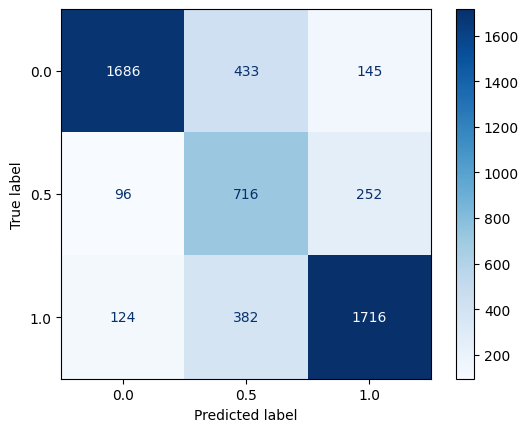

In [24]:
# Convert [0.0, 0.5, 1.0] → [0, 1, 2]
float_to_int = {0.0: 0, 0.5: 1, 1.0: 2}
int_preds = np.vectorize(float_to_int.get)(all_preds)
int_labels = np.vectorize(float_to_int.get)(all_labels)

# Now generate the confusion matrix
cm = confusion_matrix(int_labels, int_preds, labels=[0, 1, 2])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["0.0", "0.5", "1.0"])
disp.plot(cmap='Blues')


In [42]:
df_predictions = pd.DataFrame(predictions, columns=columns)
df_predictions = df_predictions.sort_values(by="Id", ascending=True)
df_predictions.head()

,Id,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Pneumonia,Pleural Effusion,Pleural Other,Fracture,Support Devices
963,100018,-0.734655,-0.275805,0.209412,0.836288,0.031183,-0.925029,0.521795,0.177863,0.888289
14253,100019,-0.734655,-0.275805,-0.716572,0.836288,0.031183,0.126851,0.521795,0.282742,0.888289
17256,100022,-0.734655,-0.275805,-0.716739,0.836288,0.031183,0.740513,0.521795,0.602488,0.888289
15017,100023,-0.734655,-0.275805,-0.613445,0.836288,0.031183,0.949374,0.521795,0.296630,0.888289
7126,100053,-0.734655,-0.275805,0.718571,0.836288,0.031183,-0.666675,0.521795,-0.006521,0.888289


In [ ]:
import os
print(os.getcwd())


/central/groups/CS156b/2025/CodeMonkeys
